# The Titanic Challenge

You should submit a csv file with exactly 418 entries plus a header row. Your submission will show an error if you have extra columns (beyond PassengerId and Survived) or rows.

The file should have exactly 2 columns:

PassengerId (sorted in any order)
Survived (contains your binary predictions: 1 for survived, 0 for deceased)

The file should have exactly 2 columns:

PassengerId,Survived
892,0
893,1
894,0
Etc.

In [102]:
# load data 
import pandas as pd

train = pd.read_csv('data/train.csv') # training data
test = pd.read_csv('data/test.csv') # test data

In [103]:
# let's collect numerical and categorical columns
X = train.drop(['Survived', 'Name'], axis=1) # only features
y = train['Survived'] # only target

In [104]:
missing_values = X.isnull().sum() # check for missing values
missing_values = missing_values[missing_values > 0] # filter columns with missing values
print(missing_values) # Age, Cabin, Embarked columns have missing values

Age         177
Cabin       687
Embarked      2
dtype: int64


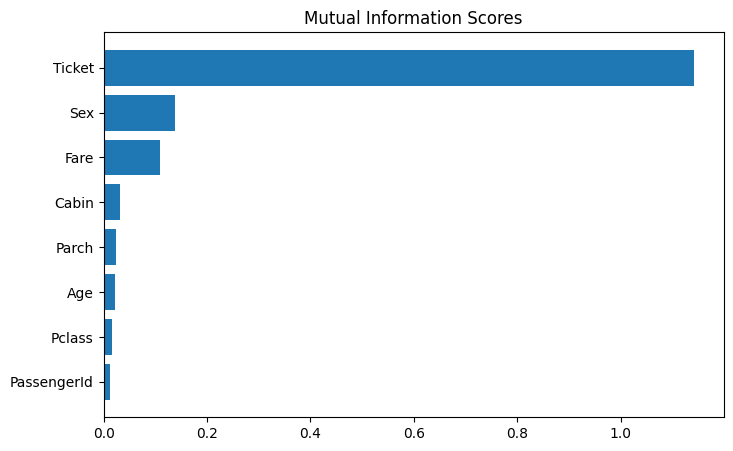

In [105]:
# Mutual Information
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
def feature_engineering(df):
    df['Age'] = df['Age'].fillna('mean') # fill missing values with mean
    # Convert Cabin to boolean
    df['Cabin']  = df['Cabin'].notna()
    
    # Extract number from Ticket by taking at lest 3 number characters by regex
    df['Ticket'] = df['Ticket'].str.extract('(\d{3,})', expand=False).fillna(0).astype(int)
    
    categorical_cols = df.select_dtypes(include=['object']).columns # select categorical columns
    
    # select only categorical columns with less than 10 unique values
    categorical_cols = [col for col in categorical_cols if df[col].nunique() < 10]
    
    # # fill missing values with most frequent value
    imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = imputer.fit_transform(df[categorical_cols])
    
    # convert categorical columns to cathegorical data type
    for colname in categorical_cols:
        df[colname], _ = df[colname].factorize()
    
    # Label encoding for categoricals
    for colname in df.select_dtypes("object"):
        df[colname], _ = df[colname].factorize()
    
    low_mi_cols = ['Embarked', 'SibSp']
    df.drop(low_mi_cols, axis=1, inplace=True)


feature_engineering(X)

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [117]:
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime as time

random_state = int(time.now().timestamp()) % 4294967295

model = RandomForestClassifier(n_estimators=50, random_state=random_state)
X_train = X.drop('PassengerId', axis=1)
X_test = test.drop(['PassengerId', 'Name'], axis=1)

feature_engineering(X_test)

model.fit(X_train, y)
predictions = model.predict(X_test)

# calculate accuracy of model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y, model.predict(X_train))
print(f"Accuracy: {accuracy}") # 0.99 % accuracy

Accuracy: 0.9966329966329966


In [114]:
from datetime import datetime as time
random_state = int(time.now().timestamp()) % 4294967295

# Define the models
model_1 = RandomForestClassifier(n_estimators=50, random_state=random_state)
model_2 = RandomForestClassifier(n_estimators=100, random_state=random_state)
model_3 = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=random_state)
model_4 = RandomForestClassifier(n_estimators=200, min_samples_split=20, random_state=random_state)
model_5 = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=random_state)

models = [model_1, model_2, model_3, model_4, model_5]

# Function for comparing different models
def score_model(_model, _train, _y):
    _model.fit(_train, _y)
    return accuracy_score(_y, _model.predict(_train))

for i in range(0, len(models)):
    mae = score_model(models[i], X_train, y)
    print(f"Model {i+1} MAE: {mae}")
    

Model 1 MAE: 0.9988776655443322
Model 2 MAE: 0.9977553310886644
Model 3 MAE: 0.9977553310886644
Model 4 MAE: 0.8911335578002245
Model 5 MAE: 0.9102132435465768


In [118]:
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('data/my_submission.csv', index=False)